In [55]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mplib
from sklearn.decomposition import PCA
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import glob
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread
%matplotlib inline

# Set general font size
plt.rcParams['font.size'] = '14'

import warnings
warnings.filterwarnings("ignore")

In [3]:
features = pd.read_csv('features_filtered.csv', encoding='latin')
features.head()

id          gen            sp  ssp             en            cnt  \
0  564895  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
1  545775  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
2  540857  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
3  540855  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
4  487506  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   

                                                 loc  \
0  Lyons Township (near  Willow Springs), Cook Co...   
1  Valley Forge National Historical Park, Montgom...   
2  Slaterville Rd @ Honness (near  Ithaca), Tompk...   
3  Slaterville Rd @ Honness (near  Ithaca), Tompk...   
4  Lake Artemesia Natural Area, Prince George's C...   

                         type         q length bird-seen  \
0  adult, sex uncertain, song  no score   0:16        no   
1                        call  no score   0:17       yes   
2                        song  no score   0:32   unknown   
3                        song  no score   0:52   unknown   
4                        song  no score   0:25       yes   

                                   file category  
0  //www.xeno-canto.org/564895/download     song  
1  //www.xeno-canto.org/545775/download     call  
2  //www.xeno-canto.org/540857/download     song  
3  //www.xeno-canto.org/540855/download     song  
4  //www.xeno-canto.org/487506/download     song

In [4]:
# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en']]
# Now we need to change our labels into integers as torch does not support string format for labels.
labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
dataset['label'] = dataset.apply(lambda row: labels[row.en], axis=1)
dataset.drop('en', axis=1, inplace=True)

In [5]:
def load_images(dataset, gray=True):
    img_df = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        image_path = 'images/mel_spectrograms_8sec/' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path)
#         # normalizing the pixel values
#         img /= 255.0
#         # converting the type of pixel to float 32
#         img = img.astype('float32')
        # appending the image into the list
        img_df.append(img.flatten())
    
    # converting the list to numpy array
    return np.array(img_df)

In [6]:
X, y = load_images(dataset, gray=True), dataset['label'].values
X.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:03<00:00, 596.82it/s]


(2371, 132480)

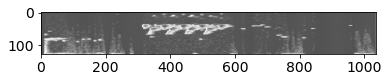

In [7]:
img = X[0].reshape(128, 1035)
plt.imshow(img, cmap='gray')

In [8]:
def pca_reduction(parameter):
    '''Parameter should be percentage variance retained (e.g. 0.95) or number of components (e.g. 2)''' 
    pca_model = PCA(parameter)
    X_proj = pca_model.fit_transform(X)
    return pca_model, X_proj

In [9]:
#Running PCA retaining 95% of the variance 
pca_95, X_proj_95 = pca_reduction(0.95)
X_proj_95.shape

(2371, 1368)

In [10]:
#Running PCA retaining 98% of the variance 
pca_98, X_proj_98 = pca_reduction(0.98)
X_proj_98.shape

(2371, 1798)

In [11]:
#Running PCA with 2 components so as to plot the data in 2D
pca_2c, X_proj_2c = pca_reduction(2)
X_proj_2c.shape

(2371, 2)

In [12]:
print(pca_2c.singular_values_)
print(np.sum(pca_2c.explained_variance_ratio_))
#We only retain about 12% of the variance by choosing 2 components

[289213.19107288 206147.45995236]
0.12169138019171086


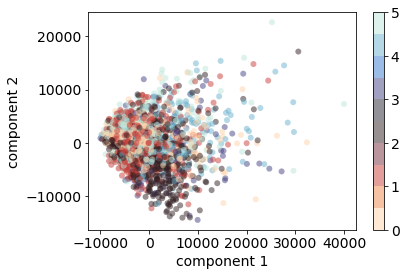

In [13]:
#Let's plot the principal components as a scatter plot
plt.scatter(X_proj_2c[:, 0], X_proj_2c[:, 1],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('icefire_r', 10)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
#This plots the 2 principal components and colors the values based on target (6 birds)

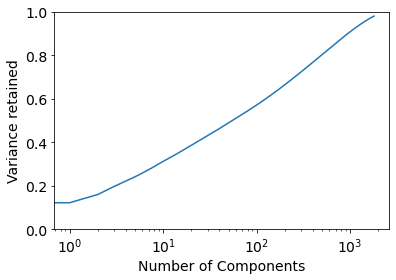

In [14]:
#How much data are we throwing away with pca_95? 
#Lets try and plot number of components versus explained variance ratio as a cumulative sum to find out 
plt.semilogx(np.cumsum(pca_98.explained_variance_ratio_)) 
plt.xlabel('Number of Components') 
plt.ylabel('Variance retained') 
plt.ylim(0,1) 
plt.show()

In [20]:
def inv_transform(pca_model, reduced_X):
    '''Reconstructs the images using the reduced dataset using inverse transform to convert images back to their
    original dimension. Note that we are not reverting back to the original data, we're going back to the actual dimension
    of the original images so that we can visualize them. 
    ''' 
    X_inv_proj = pca_model.inverse_transform(reduced_X) 
    #reshaping as 2371 images of 128*1035 dimension 
    X_proj_img = np.reshape(X_inv_proj,(2371 , 128, 1035))
    return X_proj_img

In [16]:
def images_plot(images, n_dim, cmap):
    '''Dimensions are of shape (128*345*3) or (128*1035)'''
    if n_dim == 3:
        fig, axes = plt.subplots(5, 4, figsize=(15, 8),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].reshape(128, 345, 3), cmap=cmap)
    elif n_dim == 2:
        fig, axes = plt.subplots(5, 2, figsize=(20, 8),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].reshape(128, 1035), cmap=cmap)
    else:
        print('not enough or too many dimensions')

def pca_components_plot(pca_model, cmap):
    fig = plt.figure(figsize=(15,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the spectrograms
    for i in range(min(len(pca_model.components_), 10)):
        ax = fig.add_subplot(5, 2, i+1, xticks=[], yticks=[])
        ax.imshow(np.reshape(pca_model.components_[i,:], (128,1035)), cmap=cmap, interpolation='nearest')
    
# Interesting! Some of the images actually look a bit better than those rendered with PCA.

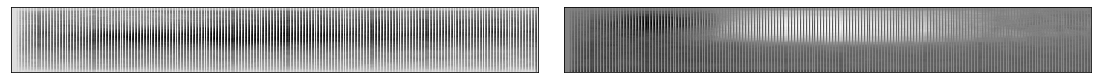

In [17]:
pca_components_plot(pca_2c, 'Greys')

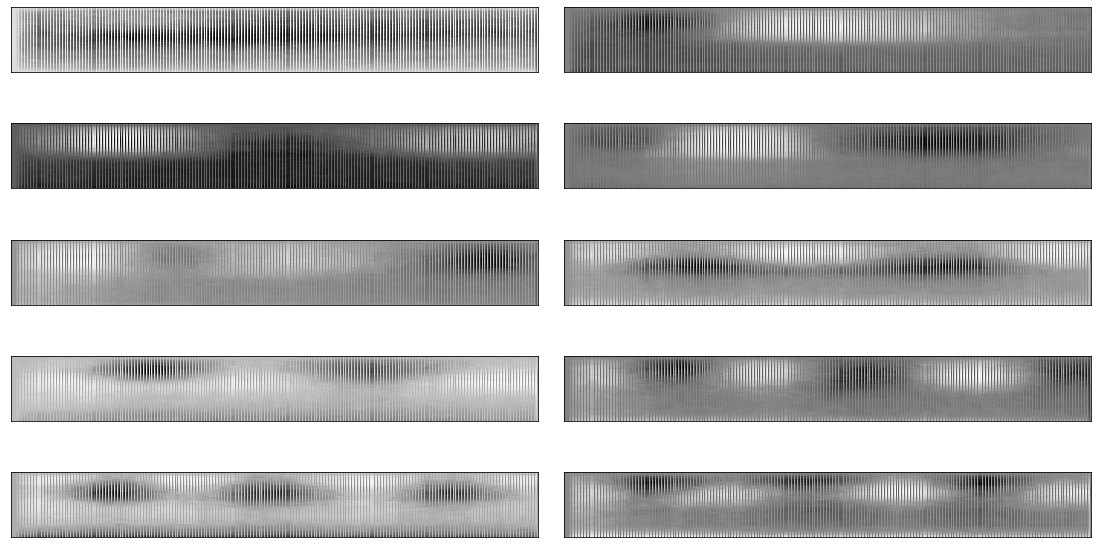

In [18]:
pca_components_plot(pca_98, 'Greys')

In [21]:
X_proj_img_98 = inv_transform(pca_98, X_proj_98)
X_proj_img_98.shape

(2371, 128, 1035)

In [22]:
X_proj_img_2c = inv_transform(pca_2c, X_proj_2c)
X_proj_img_2c.shape

(2371, 128, 1035)

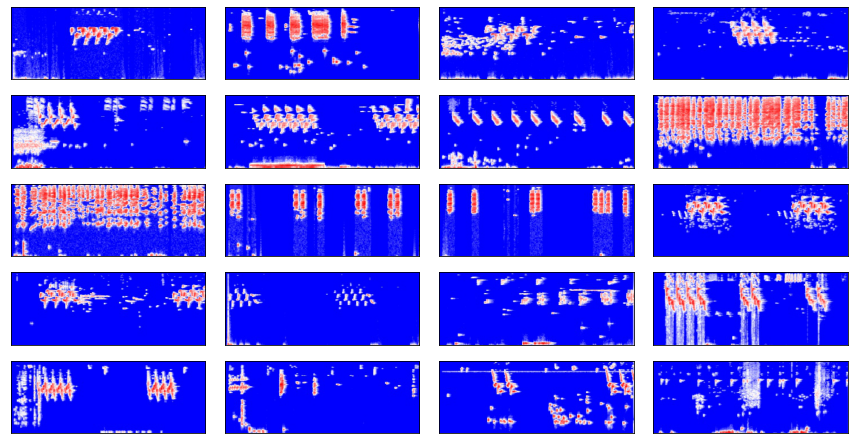

In [23]:
# Let's show the original images in 2D
images_plot(X, 3, 'bwr')

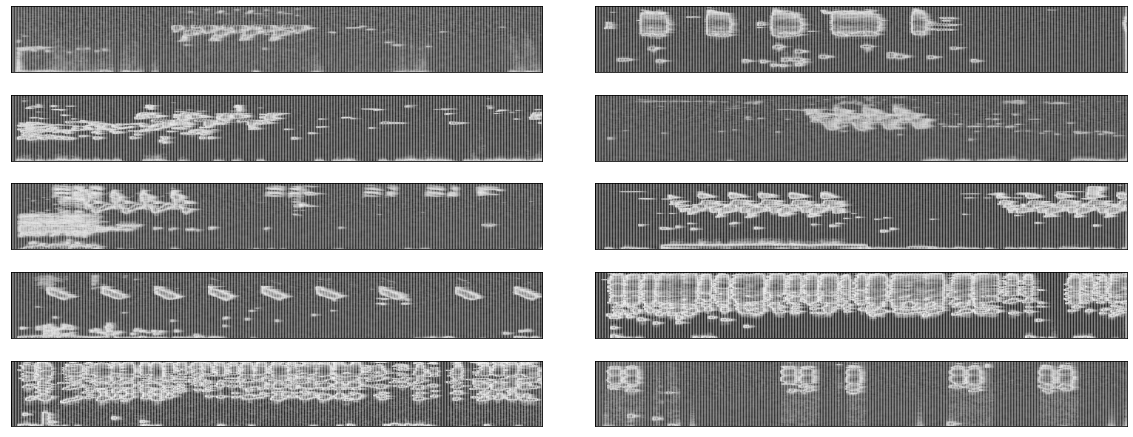

In [24]:
# Showing the pca-reduced images
images_plot(X_proj_img_98, 2, 'gray')

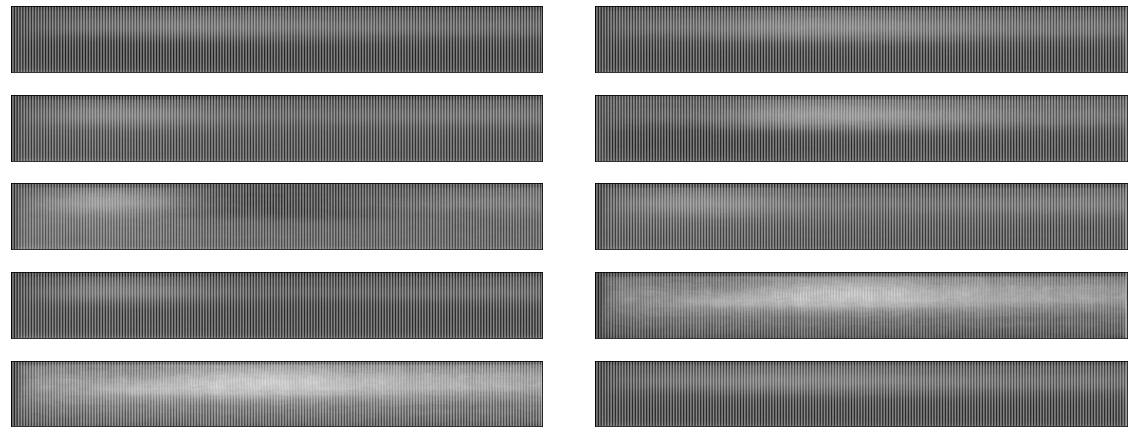

In [25]:
images_plot(X_proj_img_2c, 2, 'gray')

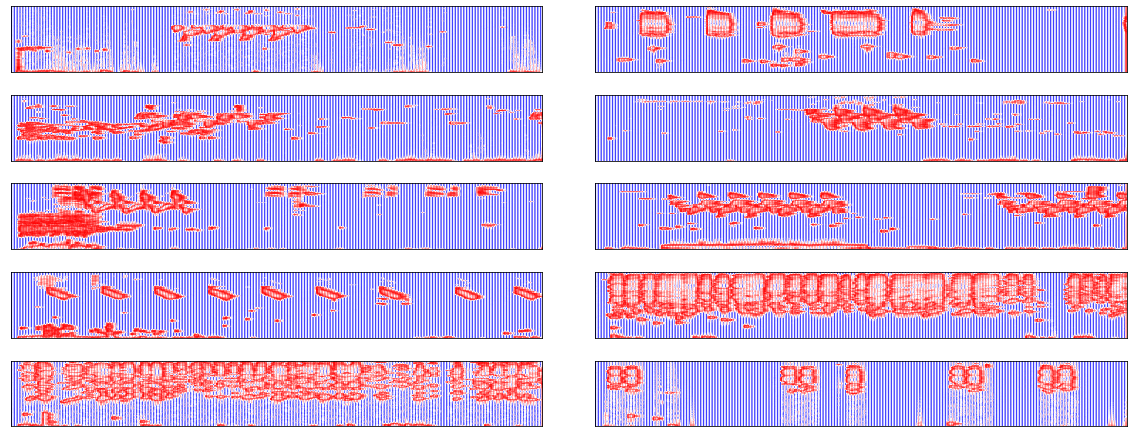

In [27]:
# Let's show the original images in 2D
images_plot(X, 2, 'bwr')

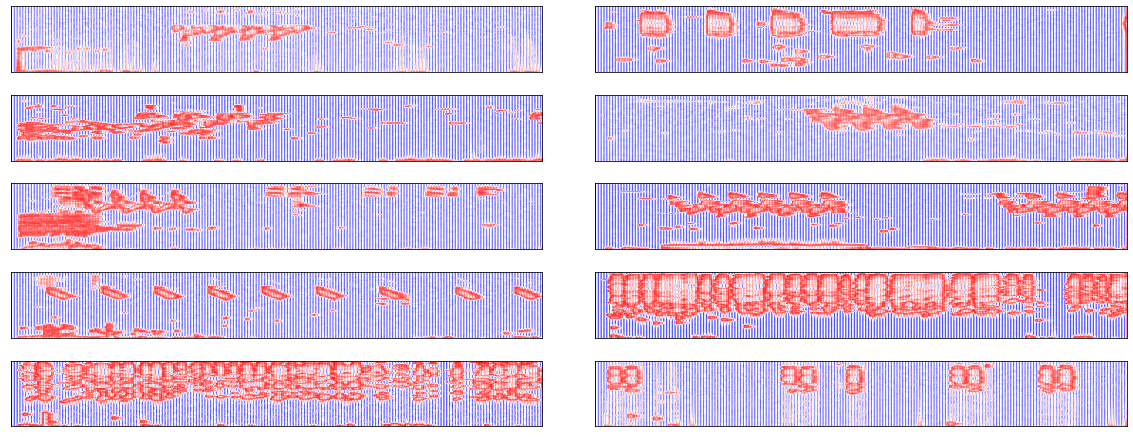

In [29]:
# Showing the pca-reduced images
images_plot(X_proj_img_98, 2, 'bwr')

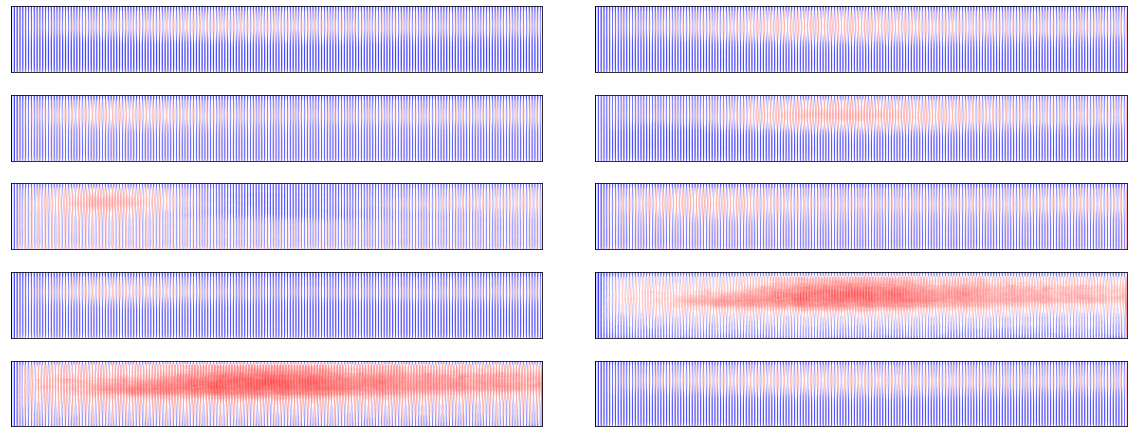

In [30]:
# Showing the pca-reduced images
images_plot(X_proj_img_2c, 2, 'bwr')

# Single image analysis

In [31]:
#Running PCA on one image retaining 95% of the variance 
pca_s95 = PCA(0.95) 
X_proj_s = pca_s95.fit_transform(X[1].reshape(128, 1035)) 
print(X[0].reshape(128, 1035).shape, X_proj_s.shape)

(128, 1035) (128, 17)


(-0.5, 67.5, 31.5, -0.5)

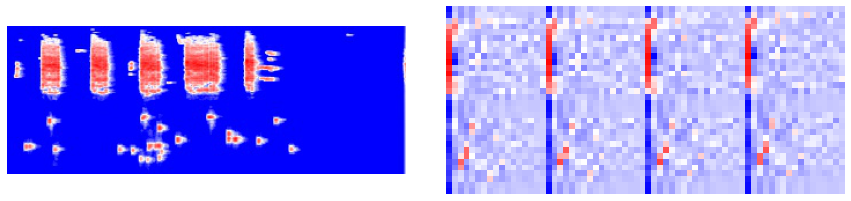

In [32]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
fig.subplots_adjust(wspace=0.1, hspace=0.15)
axes[0].imshow(X[1].reshape(128, 345, 3), cmap='bwr')
axes[0].axis('off');
#axes[1].figure(figsize=(img_shape[0]/150,img_shape[1]/150))
axes[1].imshow(X_proj_s.reshape(32, 68), cmap='bwr')
axes[1].axis('off')

In [33]:
#Running PCA on one image retaining 95% of the variance 
pca_s98 = PCA(0.98) 
X_proj_s98 = pca_s98.fit_transform(X[1].reshape(128, 1035)) 
print(X[0].reshape(128, 1035).shape, X_proj_s98.shape)

(128, 1035) (128, 31)


(-0.5, 123.5, 31.5, -0.5)

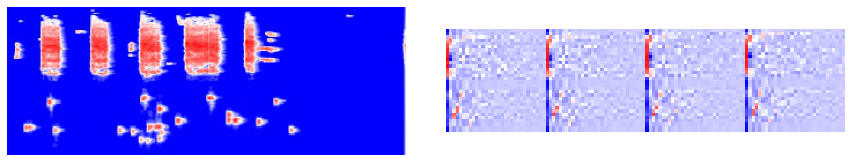

In [36]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
fig.subplots_adjust(wspace=0.1, hspace=0.15)
axes[0].imshow(X[1].reshape(128, 345, 3), cmap='bwr')
axes[0].axis('off');
#axes[1].figure(figsize=(img_shape[0]/150,img_shape[1]/150))
axes[1].imshow(X_proj_s98.reshape(32, 124), cmap='bwr')
axes[1].axis('off')

In [37]:
t = pca_98.transform(X[1].reshape(1, -1))
t.shape

(1, 1798)

(128, 345, 3)
(128, 1035)


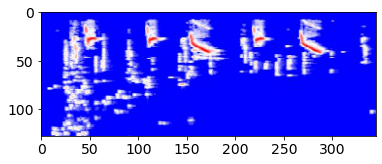

In [41]:
# Import image
img = mplib.imread('images/mel_spectrograms_8sec/1282.jpg')
img_r = np.reshape(img, (img.shape[0], img.shape[1]*img.shape[2])) 
print(img.shape), print(img_r.shape)
plt.imshow(img)

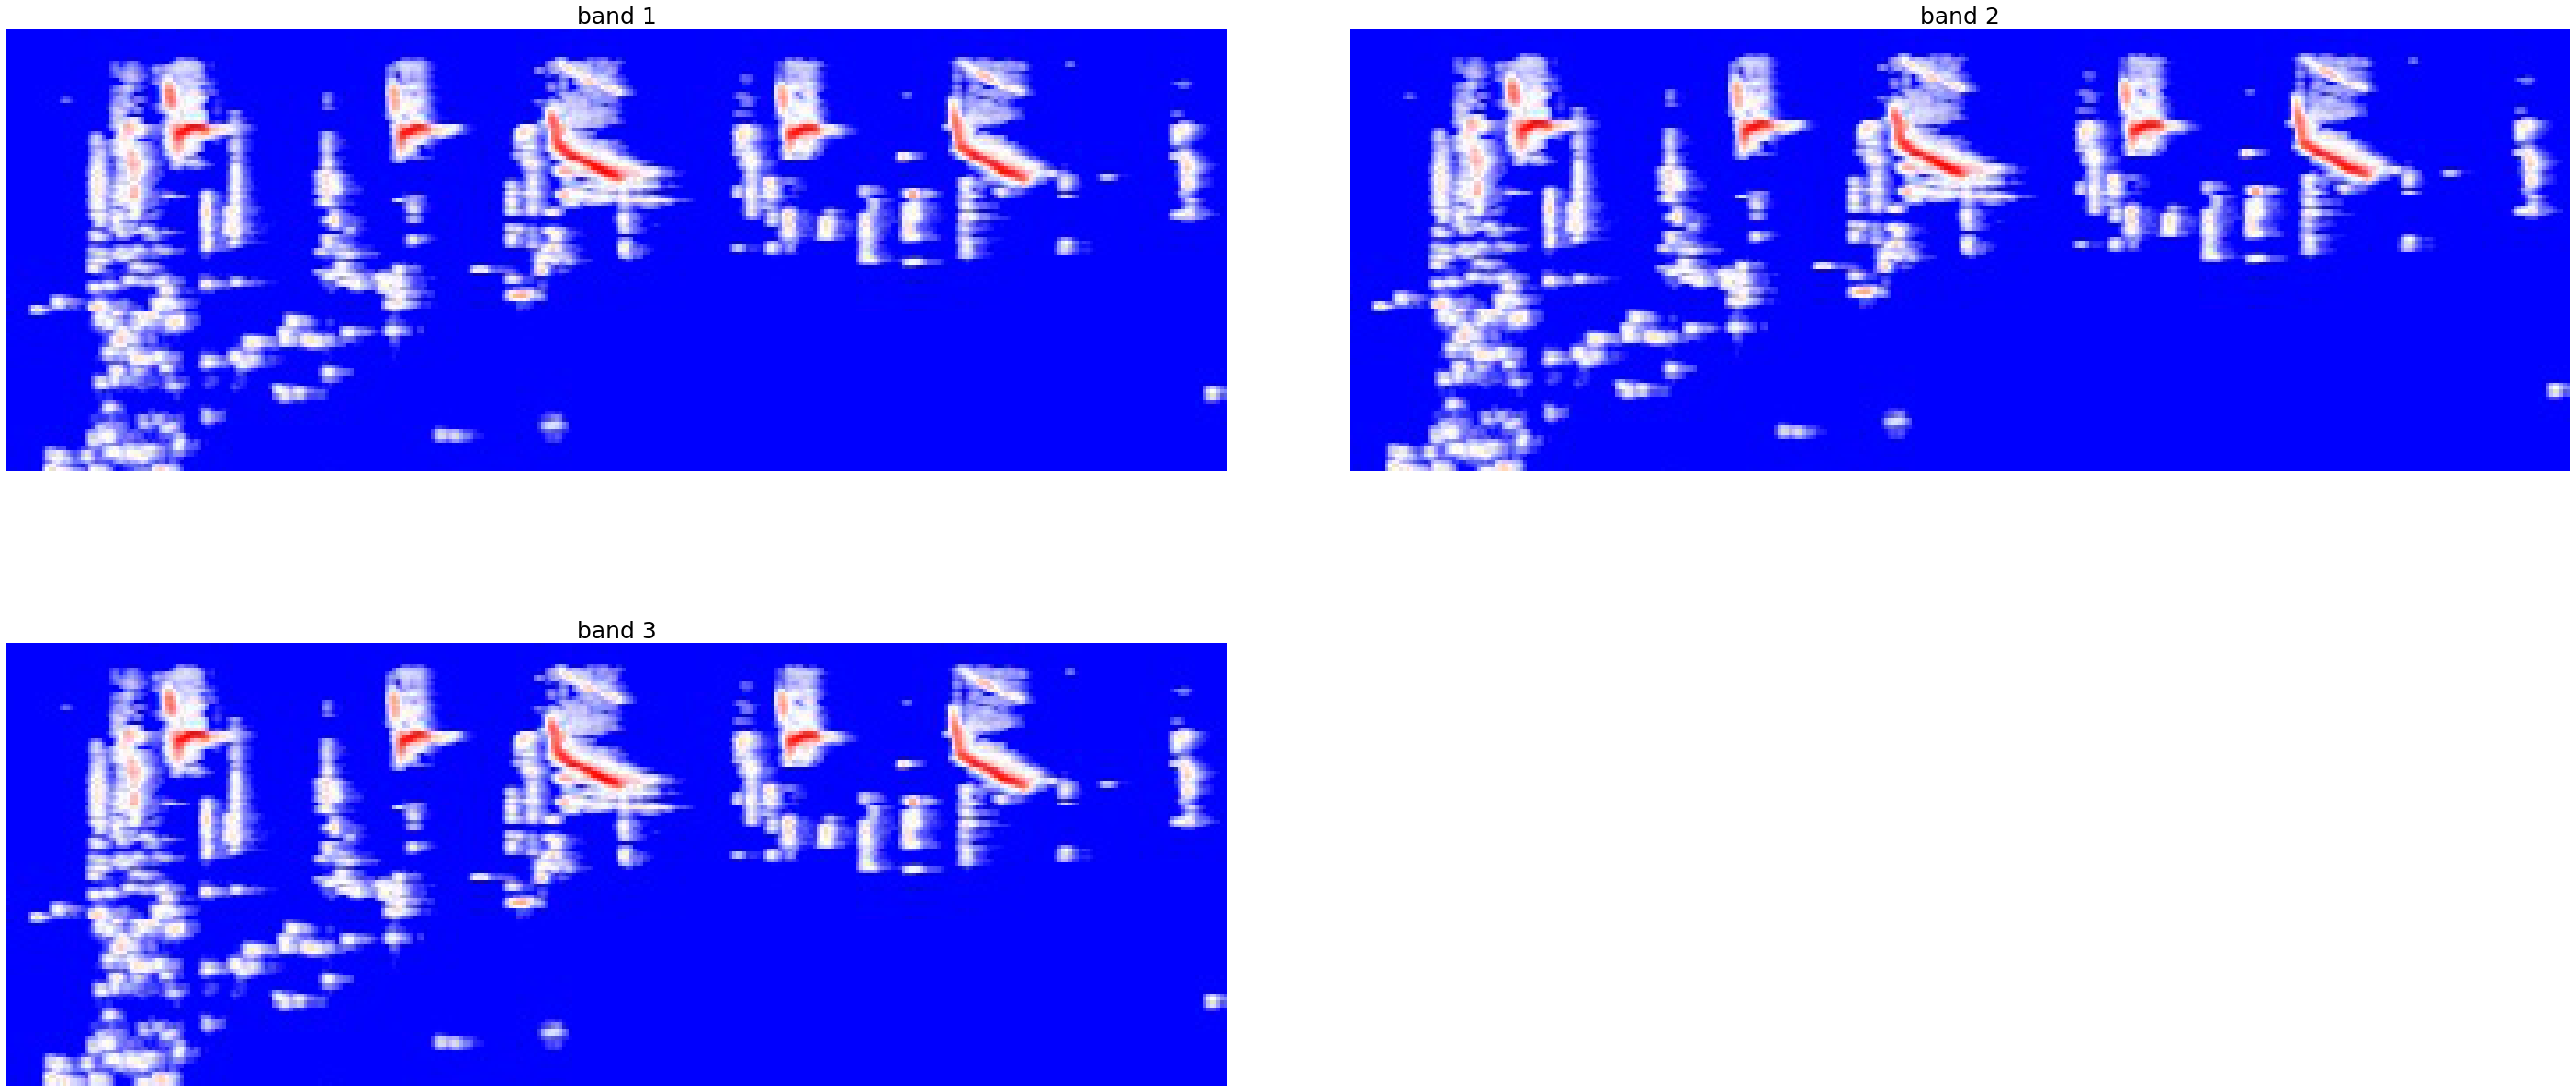

In [42]:
import matplotlib.gridspec as grid

fig,axes = plt.subplots(2,2,figsize=(50,23),sharex='all', sharey='all')
fig.subplots_adjust(wspace=0.1, hspace=0.15)
axes = axes.ravel()

for i in range(4):
    axes[i].imshow(img[i:,:,:])
    axes[i].set_title('band '+str(i+1),fontsize=25)
    axes[i].axis('off')
fig.delaxes(axes[-1])

In [43]:
MB_matrix = np.zeros((img[:,:,0].size,3))
for i in range(3):
    MB_array = img[:,:,i].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  # Standardize each variable 
    MB_matrix[:,i] = MB_arrayStd
MB_matrix.shape

(44160, 3)

In [44]:
# Covariance
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix.transpose())

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)

print("Eigen values:\n\n", EigVal,"\n")

Eigen values:

 [2.107 0.006 0.887] 



In [45]:
# Ordering Eigen values and vectors
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(MB_matrix,EigVec)   #cross product

Text(0.5, 0.98, 'Pair plot of PCs')

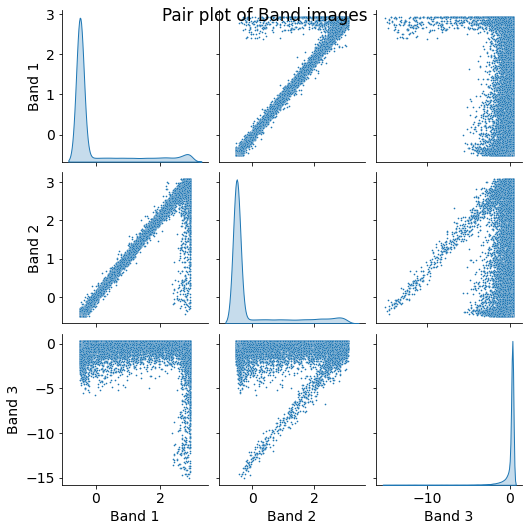

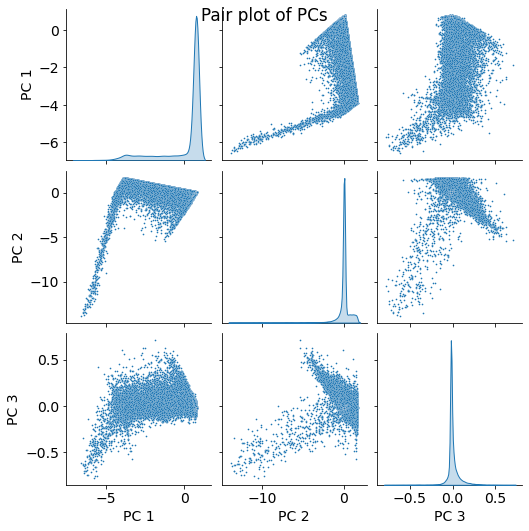

In [46]:
a = sns.pairplot(pd.DataFrame(MB_matrix,columns = ['Band 1','Band 2','Band 3']),diag_kind='kde',plot_kws={"s": 3})
a.fig.suptitle("Pair plot of Band images")
b = sns.pairplot(pd.DataFrame(PC, columns = ['PC 1','PC 2','PC 3']),diag_kind='kde',plot_kws={"s": 3})
b.fig.suptitle("Pair plot of PCs")


First 2 PCs retain 99 % of information


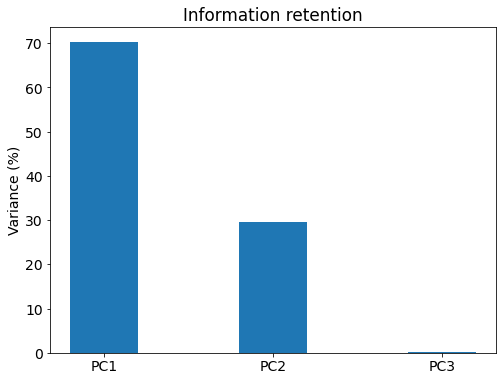

In [47]:
plt.figure(figsize=(8,6))
plt.bar([1,2,3],EigVal/sum(EigVal)*100,align='center',width=0.4,tick_label = ['PC1','PC2','PC3'])
plt.ylabel('Variance (%)')
plt.title('Information retention');

print("\nFirst 2 PCs retain "+str(int(sum(EigVal[:2])/sum(EigVal)*100))+" % of information")

In [56]:
# Rearranging 1-d arrays to 2-d arrays of image size
PC_2d = np.zeros((img.shape[0],img.shape[1],3))
for i in range(3):
    PC_2d[:,:,i] = PC[:,i].reshape(-1,img.shape[1])

# narmalizing between 0 to 255
PC_2d_Norm = np.zeros((img.shape[0],img.shape[1],3))
for i in range(3):
    PC_2d_Norm[:,:,i] = cv2.normalize(PC_2d[:,:,i],  np.zeros(img.shape[:2]),0,255 ,cv2.NORM_MINMAX)

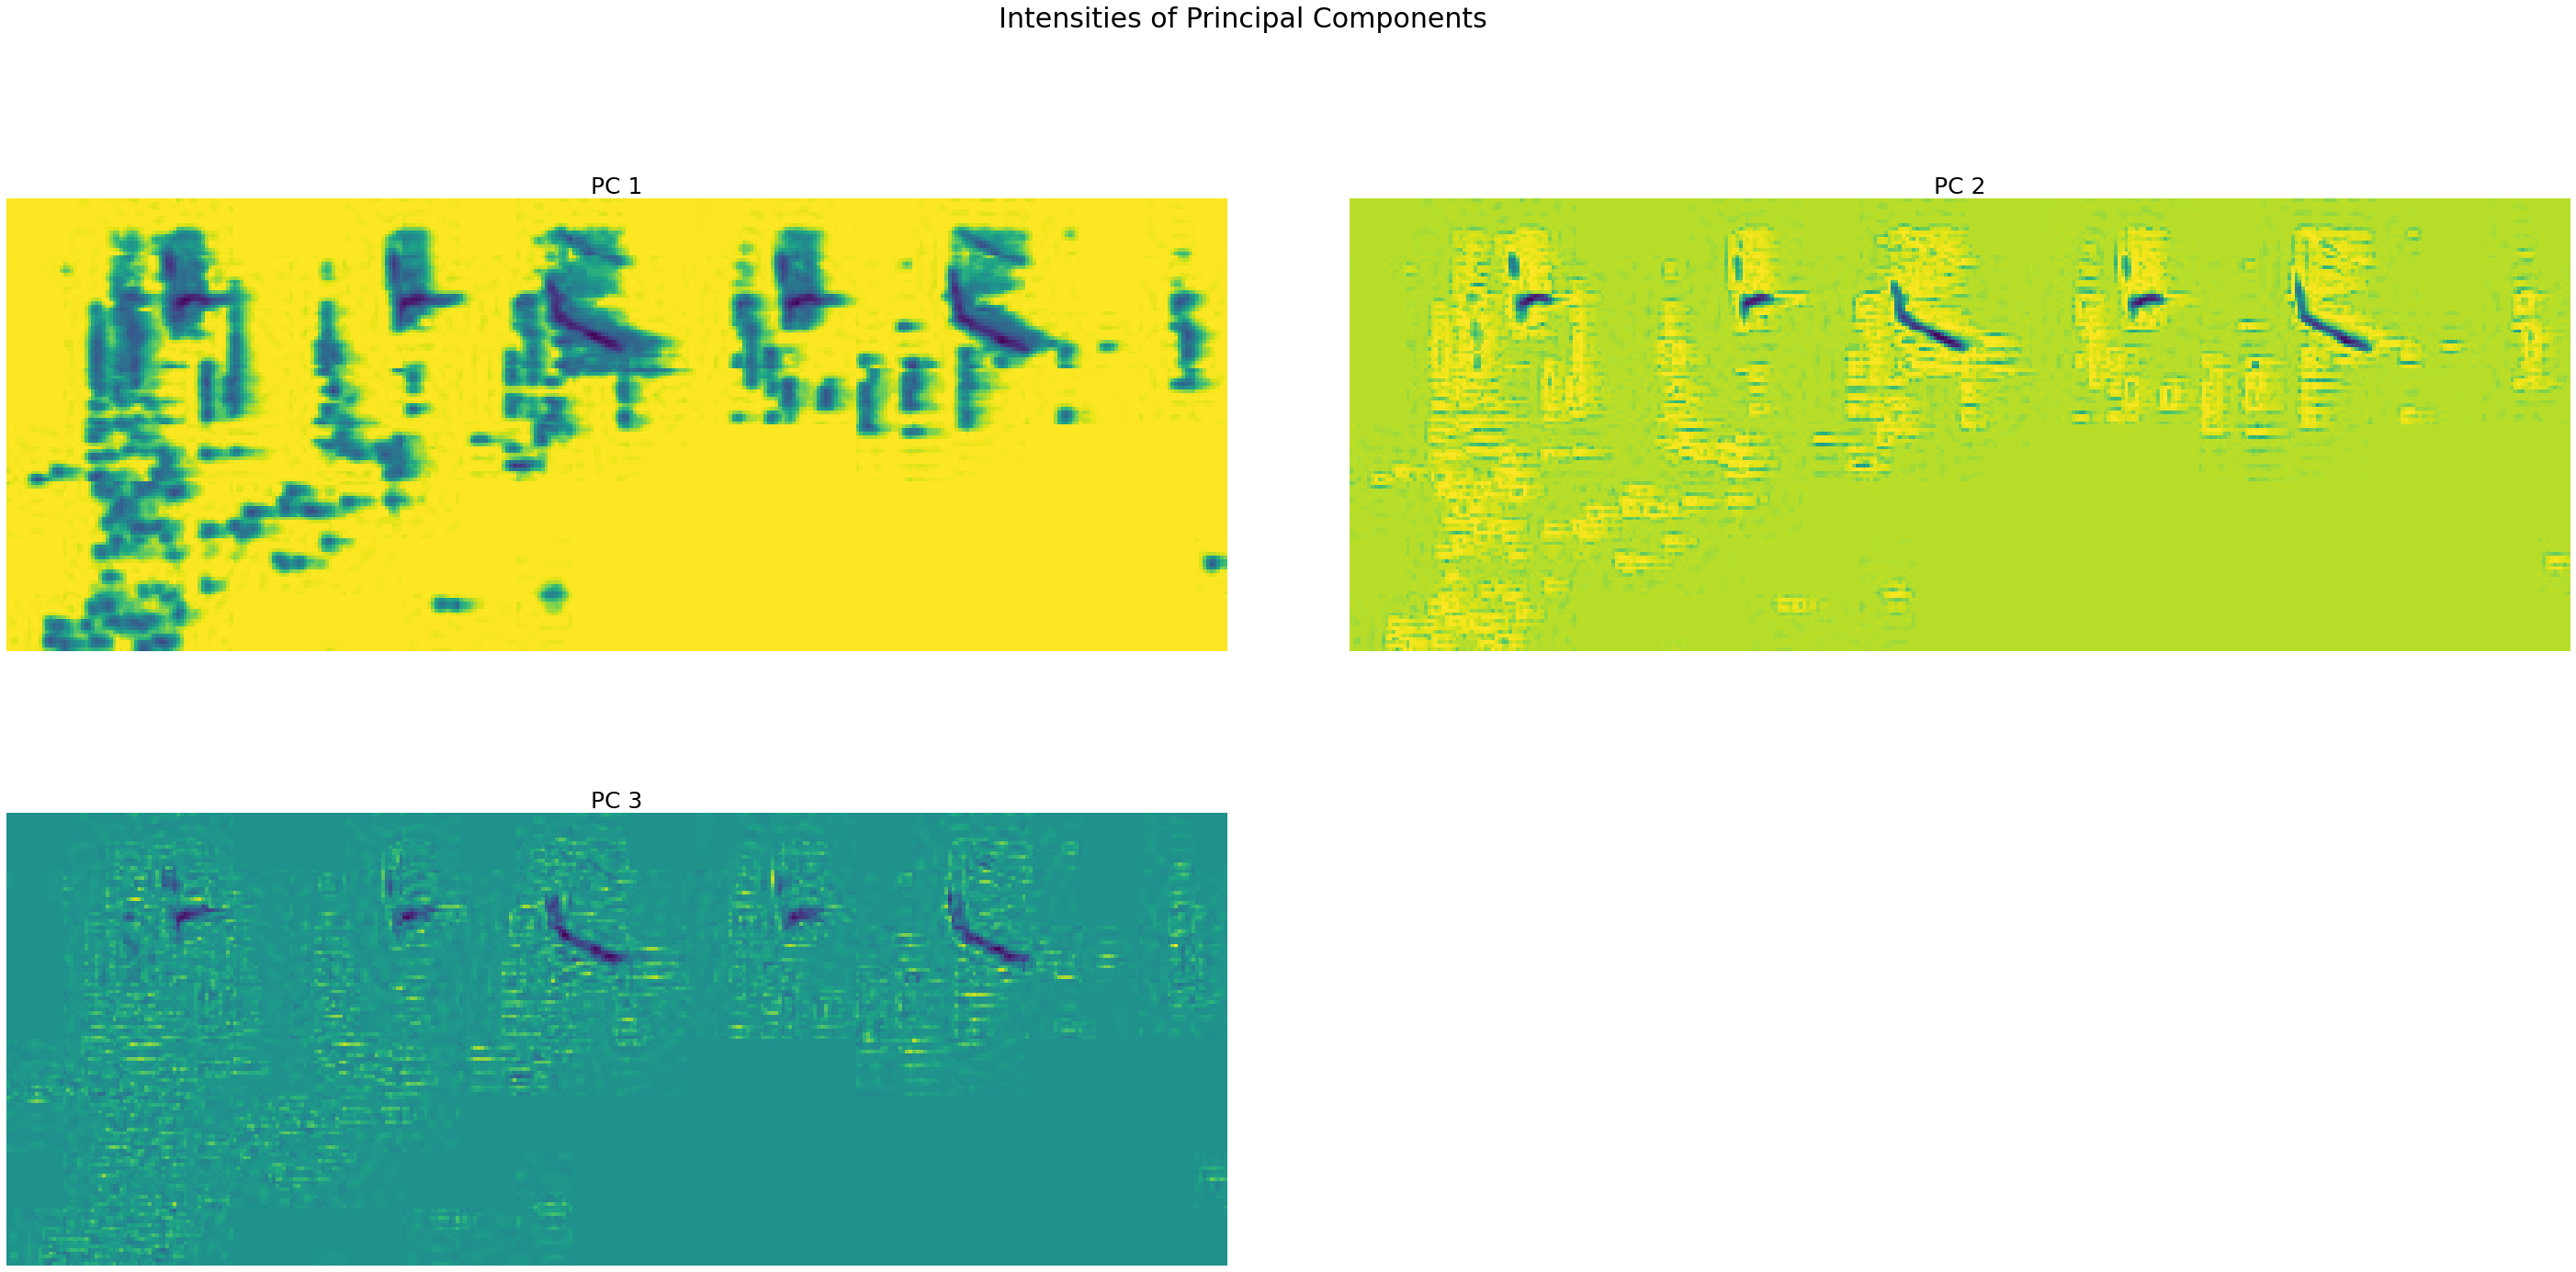

In [57]:
fig,axes = plt.subplots(2,2,figsize=(50,23),sharex='all', sharey='all')   #img_shape[0]/50,img_shape[1]/50
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Intensities of Principal Components ', fontsize=30)


axes = axes.ravel()
for i in range(3):
    axes[i].imshow(PC_2d_Norm[:,:,i])
    axes[i].set_title('PC '+str(i+1),fontsize=25)
    axes[i].axis('off')
fig.delaxes(axes[-1])

(-0.5, 344.5, 127.5, -0.5)

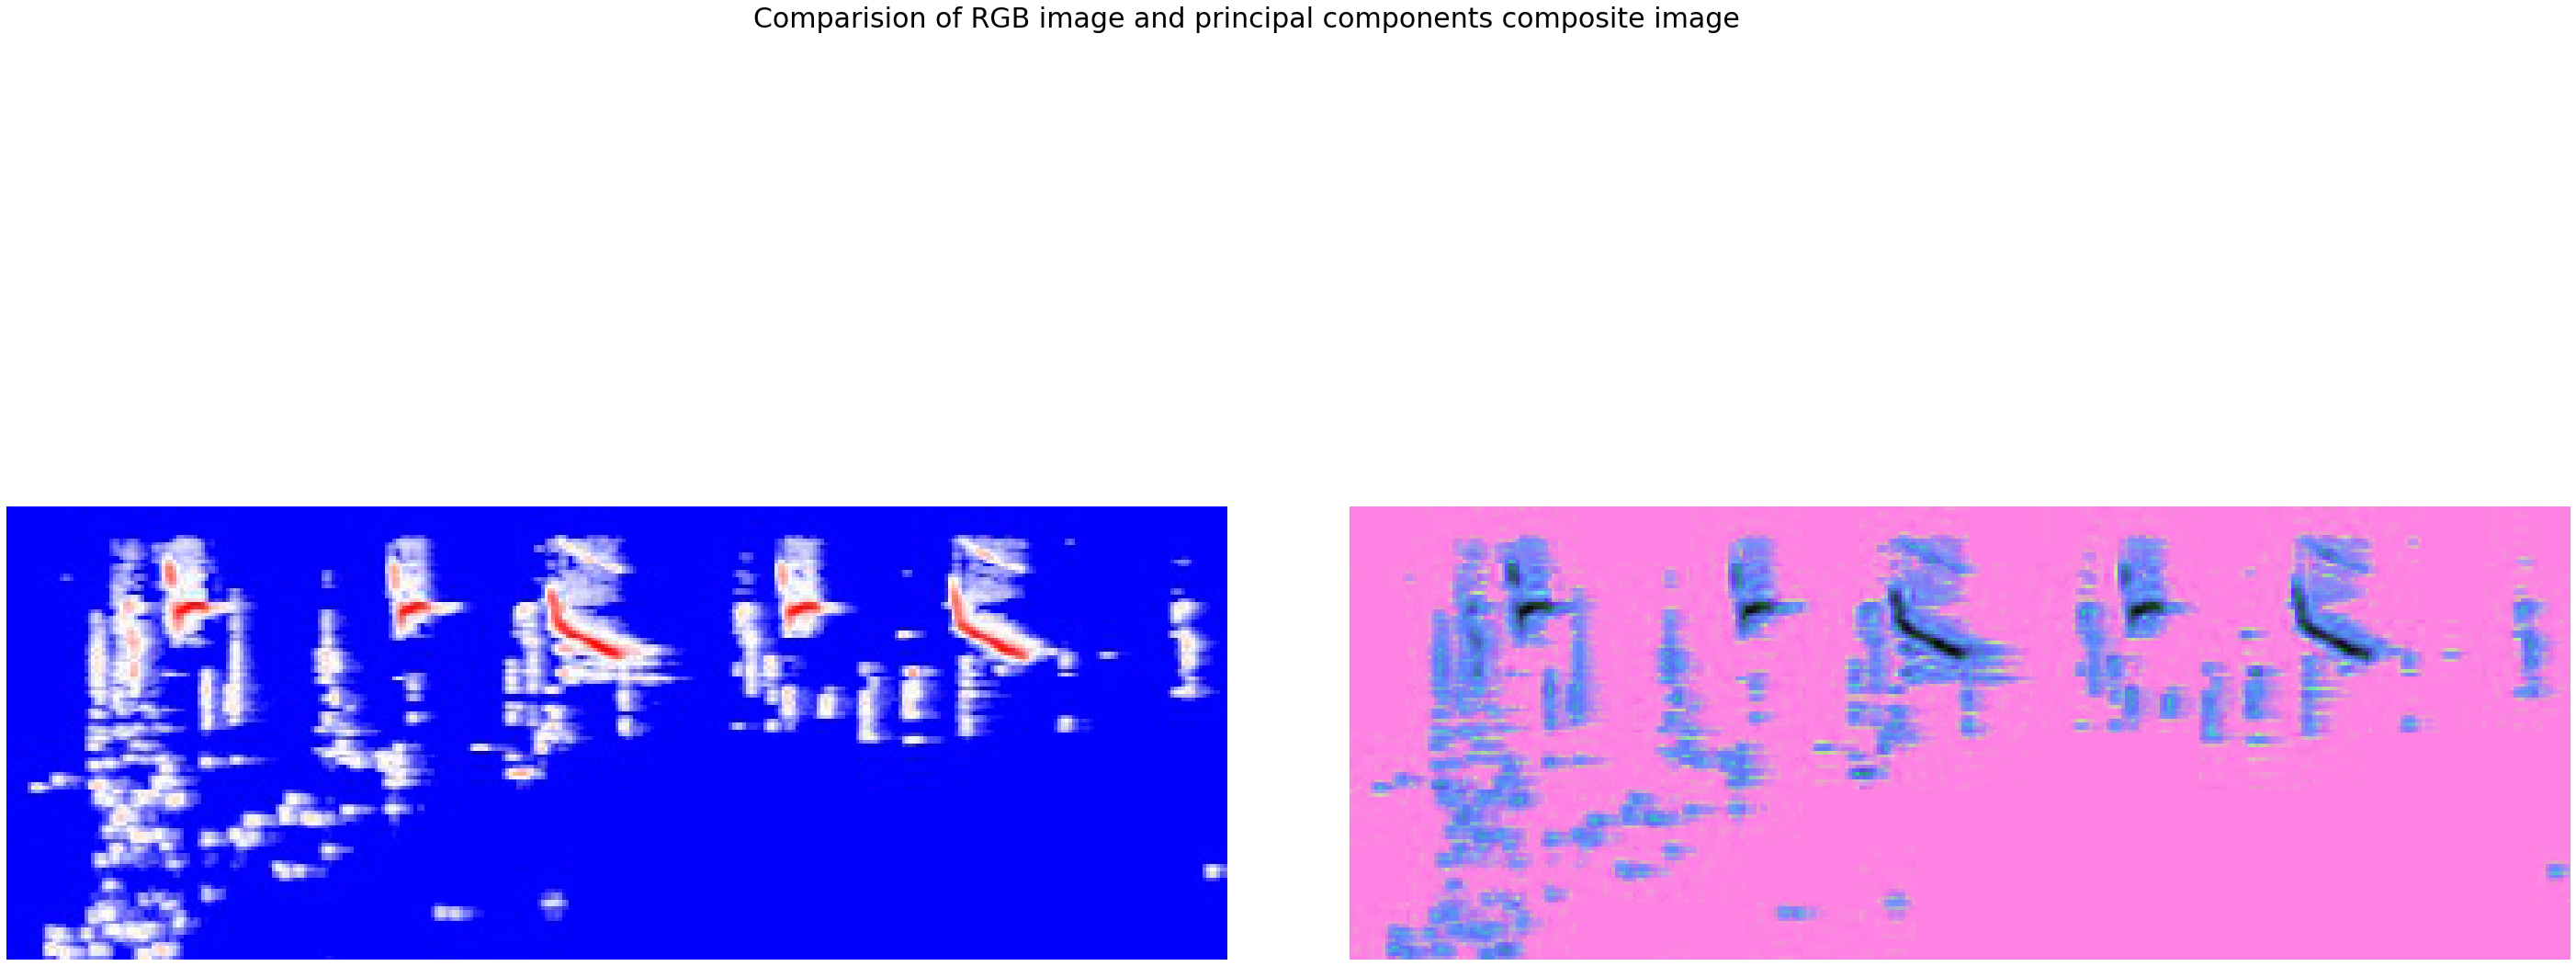

In [58]:
# Comparsion of RGB and Image produced using first three bands
fig,axes = plt.subplots(1,2,figsize=(50,23),sharex='all', sharey='all')   #img_shape[0]/50,img_shape[1]/50
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Comparision of RGB image and principal components composite image', fontsize=30)
axes[0].imshow(img[:,:,0:3].astype(int))
axes[0].axis('off');
#axes[1].figure(figsize=(img_shape[0]/150,img_shape[1]/150))
axes[1].imshow(PC_2d_Norm[:,:,:3][:,:,[0,2,1]].astype(int))
axes[1].axis('off')

In [62]:
# Reshaping the image to 2-dimensional so we are multiplying columns with depth so 225 X 3 = 675.
img_r = np.reshape(img, (115, 1152)) 
print(img_r.shape) 

(115, 1152)
